In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import torch
import torchvision
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('../')
import dataset
from model import ResNet18YOLOv1
from loss import YOLOv1Loss
import matplotlib.patches as patches

In [63]:
pascal_voc_train = torchvision.datasets.VOCDetection(
    root="../data",
    year="2007",
    image_set="train",
    download=False
)

In [64]:
voc_train = dataset.PascalVOC(pascal_voc=pascal_voc_train)

TRANSFORMING PASCAL VOC


In [65]:
data = voc_train[0]
resize = torchvision.transforms.Resize((448, 448))

data = (resize(data[0]).unsqueeze(0), data[1].unsqueeze(0))

data[0].shape, data[1].shape

(torch.Size([1, 3, 448, 448]), torch.Size([1, 7, 7, 25]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


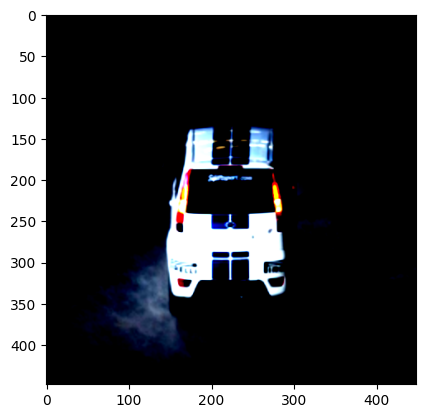

In [66]:
img = data[0].squeeze(0).permute((1, 2, 0))

plt.imshow(img)

In [67]:
Y = data[1][0][3]
Y

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       

In [68]:
device = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

device

device(type='mps')

In [69]:
# hyperparameters
S = 7
B = 2
C = 20
lambda_coord = 5
lambda_noobj = 0.5

In [70]:
yolo = ResNet18YOLOv1(
    S=7,
    B=2,
    C=20
)

yolo = yolo.to(device)

In [71]:
yolo(data[0].to(device))

tensor([[[[0.5072, 0.3579, 0.5301,  ..., 0.4768, 0.3645, 0.5425],
          [0.5820, 0.4420, 0.5018,  ..., 0.6583, 0.3889, 0.4690],
          [0.4502, 0.4856, 0.5144,  ..., 0.5242, 0.4895, 0.5134],
          ...,
          [0.5976, 0.6060, 0.4790,  ..., 0.5967, 0.3243, 0.5669],
          [0.4582, 0.4950, 0.4856,  ..., 0.4899, 0.6400, 0.5131],
          [0.6081, 0.5484, 0.3929,  ..., 0.3174, 0.4843, 0.4441]],

         [[0.4779, 0.4843, 0.4307,  ..., 0.4226, 0.5550, 0.4748],
          [0.5881, 0.4182, 0.4236,  ..., 0.4246, 0.5131, 0.4226],
          [0.5071, 0.5570, 0.5202,  ..., 0.5229, 0.4066, 0.5118],
          ...,
          [0.4717, 0.5344, 0.5908,  ..., 0.4587, 0.5663, 0.4917],
          [0.5870, 0.3578, 0.4515,  ..., 0.6515, 0.7135, 0.4826],
          [0.5156, 0.4146, 0.5313,  ..., 0.4256, 0.5958, 0.6667]],

         [[0.6311, 0.3602, 0.6339,  ..., 0.6731, 0.3764, 0.5032],
          [0.4580, 0.3192, 0.5027,  ..., 0.5952, 0.5989, 0.5478],
          [0.4279, 0.4719, 0.4611,  ..., 0

In [72]:
yolo_loss = YOLOv1Loss(
    S=S,
    B=B,
    C=20,
    lambda_coord=lambda_coord,
    lambda_noobj=lambda_noobj
)

optimizer = torch.optim.SGD(yolo.parameters(), lr=1e-4, momentum=0.9)
# optimizer = torch.optim.Adam(yolo.parameters(), lr=1e-4)

In [73]:
pred = yolo(data[0].to(device))
target = data[1].to(device)
yolo_loss(pred, target)

obj confidence: 0.1845463067293167, noobj confidence: 12.242227554321289
localization: 0.7255285978317261, confidence: 12.426774024963379, classification: 5.067468643188477


tensor(18.2198, device='mps:0', grad_fn=<DivBackward0>)

In [74]:
EPOCHS = 20

In [84]:
print("TRAINING")

yolo.train()

for epoch in tqdm(range(EPOCHS)):
    X, Y = data
    
    X = X.to(device)
    Y = Y.to(device)
    
    pred = yolo(X)
    loss = yolo_loss(pred, Y)
    
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    print(f"EPOCH {epoch + 1}: Loss={loss}")

TRAINING


  5%|██▏                                         | 1/20 [00:00<00:03,  5.30it/s]

obj confidence: 0.034365616738796234, noobj confidence: 0.08849208056926727
localization: 0.3370400667190552, confidence: 0.12285769730806351, classification: 0.00728791207075119
EPOCH 1: Loss=0.4671856760978699
obj confidence: 0.01070477906614542, noobj confidence: 0.041845887899398804
localization: 0.6951485872268677, confidence: 0.05255066603422165, classification: 0.003354034386575222
EPOCH 2: Loss=0.7510532736778259
obj confidence: 0.0001529316941741854, noobj confidence: 0.07788296788930893
localization: 0.9217023849487305, confidence: 0.07803589850664139, classification: 0.006256420165300369


 15%|██████▌                                     | 3/20 [00:00<00:01,  8.88it/s]

EPOCH 3: Loss=1.0059946775436401
obj confidence: 0.0006435028044506907, noobj confidence: 0.03812926635146141
localization: 0.8899216055870056, confidence: 0.03877276927232742, classification: 0.0018914935644716024


 25%|███████████                                 | 5/20 [00:00<00:01, 10.10it/s]

EPOCH 4: Loss=0.9305858612060547
obj confidence: 0.027079878374934196, noobj confidence: 0.014921684749424458
localization: 0.2796246111392975, confidence: 0.04200156405568123, classification: 0.001022058306261897
EPOCH 5: Loss=0.3226482570171356
obj confidence: 0.019087297841906548, noobj confidence: 0.02848738431930542
localization: 0.9903631806373596, confidence: 0.04757468402385712, classification: 0.003051659557968378
EPOCH 6: Loss=1.0409895181655884
obj confidence: 0.01688033901154995, noobj confidence: 0.01837637647986412
localization: 0.4909208416938782, confidence: 0.03525671362876892, classification: 0.001659151865169406


 35%|███████████████▍                            | 7/20 [00:00<00:01, 10.59it/s]

EPOCH 7: Loss=0.5278366804122925
obj confidence: 0.03860955312848091, noobj confidence: 0.021833891049027443
localization: 0.35827451944351196, confidence: 0.0604434460401535, classification: 0.0005880724638700485
EPOCH 8: Loss=0.41930603981018066
obj confidence: 0.15857212245464325, noobj confidence: 0.007378960028290749
localization: 0.41868987679481506, confidence: 0.16595108807086945, classification: 0.001834088354371488


 45%|███████████████████▊                        | 9/20 [00:00<00:01, 10.91it/s]

EPOCH 9: Loss=0.5864750742912292
obj confidence: 0.43352848291397095, noobj confidence: 0.008961506187915802
localization: 1.1883232593536377, confidence: 0.44248998165130615, classification: 9.765604045242071e-05


 55%|███████████████████████▋                   | 11/20 [00:01<00:00, 11.00it/s]

EPOCH 10: Loss=1.630910873413086
obj confidence: 0.13294191658496857, noobj confidence: 0.021861553192138672
localization: 0.3243121802806854, confidence: 0.15480346977710724, classification: 0.0014995154924690723
EPOCH 11: Loss=0.48061516880989075
obj confidence: 0.47045066952705383, noobj confidence: 0.007595118135213852
localization: 0.666888952255249, confidence: 0.478045791387558, classification: 0.0002497115056030452
EPOCH 12: Loss=1.1451845169067383
obj confidence: 0.02192508429288864, noobj confidence: 0.018645893782377243
localization: 0.959823727607727, confidence: 0.040570978075265884, classification: 0.0016492413124069571


 65%|███████████████████████████▉               | 13/20 [00:01<00:00, 11.20it/s]

EPOCH 13: Loss=1.0020439624786377
obj confidence: 0.01326976902782917, noobj confidence: 0.007444176357239485
localization: 1.23307466506958, confidence: 0.020713945850729942, classification: 0.0006787666352465749
EPOCH 14: Loss=1.2544673681259155
obj confidence: 0.011905036866664886, noobj confidence: 0.011263251304626465
localization: 1.8613383769989014, confidence: 0.02316828817129135, classification: 0.0008175863767974079


 75%|████████████████████████████████▎          | 15/20 [00:01<00:00, 11.34it/s]

EPOCH 15: Loss=1.885324239730835
obj confidence: 0.04152859002351761, noobj confidence: 0.0070353299379348755
localization: 1.1294689178466797, confidence: 0.048563919961452484, classification: 0.00038349672104232013


 85%|████████████████████████████████████▌      | 17/20 [00:01<00:00, 11.37it/s]

EPOCH 16: Loss=1.17841637134552
obj confidence: 0.03947827219963074, noobj confidence: 0.030650153756141663
localization: 1.2257803678512573, confidence: 0.0701284259557724, classification: 0.001339406007900834
EPOCH 17: Loss=1.2972482442855835
obj confidence: 0.03772502392530441, noobj confidence: 0.01988118886947632
localization: 0.9915441274642944, confidence: 0.05760621279478073, classification: 0.0009183894144371152
EPOCH 18: Loss=1.050068736076355
obj confidence: 0.1247735396027565, noobj confidence: 0.00989830493927002
localization: 0.5482273101806641, confidence: 0.13467183709144592, classification: 0.0009678815840743482


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 10.84it/s]

EPOCH 19: Loss=0.6838669776916504
obj confidence: 0.02702888287603855, noobj confidence: 0.006128157023340464
localization: 1.1283965110778809, confidence: 0.03315703943371773, classification: 0.0002666921936906874
EPOCH 20: Loss=1.1618201732635498


In [85]:
Y = data[1]
Y[0][3][3]

tensor([1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [86]:
X = data[0]
X

tensor([[[[-0.9498, -0.9587, -0.9765,  ..., -1.1729, -1.2027, -1.2177],
          [-0.9520, -0.9604, -0.9772,  ..., -1.1582, -1.1850, -1.1983],
          [-0.9564, -0.9638, -0.9785,  ..., -1.1289, -1.1494, -1.1597],
          ...,
          [-0.7562, -0.7544, -0.7509,  ..., -0.7217, -0.7242, -0.7254],
          [-0.7283, -0.7281, -0.7277,  ..., -0.7439, -0.7488, -0.7512],
          [-0.7144, -0.7150, -0.7161,  ..., -0.7550, -0.7611, -0.7642]],

         [[-0.8415, -0.8506, -0.8688,  ..., -1.0468, -1.0692, -1.0804],
          [-0.8438, -0.8524, -0.8695,  ..., -1.0318, -1.0510, -1.0606],
          [-0.8483, -0.8558, -0.8709,  ..., -1.0018, -1.0146, -1.0211],
          ...,
          [-0.6611, -0.6603, -0.6587,  ..., -0.6118, -0.6120, -0.6121],
          [-0.6326, -0.6334, -0.6350,  ..., -0.6314, -0.6362, -0.6385],
          [-0.6184, -0.6200, -0.6232,  ..., -0.6412, -0.6483, -0.6518]],

         [[-0.6504, -0.6538, -0.6607,  ..., -0.8313, -0.8576, -0.8708],
          [-0.6527, -0.6562, -

In [87]:
X = data[0].to(device)
pred = yolo(X)
pred.shape

torch.Size([1, 7, 7, 30])

In [88]:
pred = pred.squeeze(0)
pred.shape

torch.Size([7, 7, 30])

In [89]:
target = pascal_voc_train[0][1]
target

{'annotation': {'folder': 'VOC2007',
  'filename': '000012.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '207539885'},
  'owner': {'flickrid': 'KevBow', 'name': '?'},
  'size': {'width': '500', 'height': '333', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'car',
    'pose': 'Rear',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}}

In [90]:
# voc_train[0][1]

In [91]:
pred = pred.view(-1, 30)
pred = pred.detach()
bboxes = []
grid_size = 448 / 7

for i in range(pred.size(0)):
    box_pred = pred[i]
    classification = box_pred[-20:]
    pred_boxes = box_pred[:-20].view(-1, 5)
    
    row = i // 7
    col = i % 7
    
    grid_x = col * grid_size
    grid_y = row * grid_size
    
    for box in pred_boxes:
        confidence = box[0]
        if confidence >= 0.5:
            # change box shape to
            x = box[1]
            y = box[2]
            w = box[3]
            h = box[4]
            
            x_center = grid_x + x * grid_size
            y_center = grid_y + y * grid_size
            width = w * 448
            height = h * 448
            
            xmin = x_center - width / 2
            xmax = x_center + width / 2
            ymin = y_center - height / 2
            ymax = y_center + height / 2
            
            # print(box)
            bbox = torch.tensor([confidence, xmin, ymin, xmax, ymax]) # add classification to this as well
            bboxes.append(bbox)
            print(classification)
            
bboxes = torch.stack(bboxes)
bboxes

RuntimeError: stack expects a non-empty TensorList

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


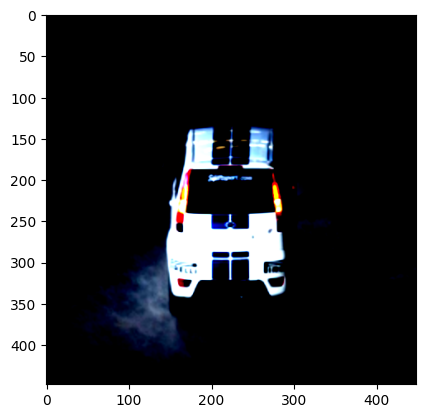

In [92]:
img = data[0].squeeze(0).permute((1, 2, 0))

fig, ax = plt.subplots()

for bbox in bboxes:
    bbox = bbox.numpy()
    xmin = bbox[1]
    ymin = bbox[2]
    width = bbox[3] - xmin
    height = bbox[4] - ymin
    
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


ax.imshow(img)